In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import numpy as np
import time
import datetime
from IPython.display import clear_output

#Data Pipeline

## Generator:
##### The create_sample() and create_dataset()-methods generate our datasets
##### The create_sample() creates one sequence of numbers and two query_digits
##### The create_dataset() puts together a dataset containing multiple different sequences of numbers

In [13]:
def create_samples(len):
  for i in range(len):
    query_digit_1 = np.random.randint(9)
    query_digit_2 = np.random.randint(9)
    while(query_digit_1 == query_digit_2):
      query_digit_2 = np.random.randint(9)
    sequence = []
    for i in range(23):
      sequence.append(np.random.randint(9))
    if (sequence.count(query_digit_1) == sequence.count(query_digit_2)):
      target  = 0
    elif (sequence.count(query_digit_1) > sequence.count(query_digit_2)):
      target = 0
    else:
      target = 1
    target = tf.one_hot(target, 3)
    sequence = tf.convert_to_tensor(sequence)
    context = tf.convert_to_tensor([query_digit_1, query_digit_2])
    
    yield sequence, context, target

In [14]:
def create_dataset(size, timesteps):
  generator = create_samples(size)
  inputs = []
  labels = []
  for i in range(size):
    sequence, context, label = next(generator)
    sequence = tf.one_hot(sequence, 10)
    context = tf.one_hot(context, 10)
    labels.append(label)
    helper = []
    for j in range(timesteps):
      helper.append(tf.concat((context, tf.expand_dims(sequence[j], axis = 0)), axis = 0))
    inputs.append(helper)

  input_dataset = tf.data.Dataset.from_tensor_slices(inputs)
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
  dataset = tf.data.Dataset.zip((input_dataset, labels_dataset))
  dataset = dataset.batch(32).prefetch(32)  
  return dataset

In [15]:
train_dataset = create_dataset(2048, 23)
test_dataset = create_dataset(320, 23)

#LSTM-Model

##### The LSTMCell-Class contains the inputgate, forgetgate, outputgate and a candidates-dense-layer
##### The call-function first concats the hidden_state and the input
##### After that the first part of the new cell_state is calculated
##### Third step is the calculation of the unput by calling the input_gate and adding it up with the result of the candidates call function
##### Finally the output is calculated by applying a tanh activation function and the output of the outputgate

In [16]:
class LSTMCell(tf.keras.Model):
  def __init__(self, state_size):
    super(LSTMCell, self).__init__()

    # dense layers
    self.inputgate = tf.keras.layers.Dense(units= state_size, activation='sigmoid')
    self.forgetgate = tf.keras.layers.Dense(units= state_size, activation='sigmoid', bias_initializer = 'ones')
    self.outputgate = tf.keras.layers.Dense(units= state_size, activation='sigmoid')
    self.candidates = tf.keras.layers.Dense(units= state_size, activation='tanh')


  def call(self, input,states):
    (hidden_state, cell_state) = states
    concat_input = tf.expand_dims(tf.concat((hidden_state, input), axis = 0), axis = 0)
    cell_state = cell_state * self.forgetgate(concat_input)
    update = self.inputgate(concat_input) * self.candidates(concat_input)
    cell_state = cell_state + update
    output = tf.keras.activations.tanh(cell_state) * self.outputgate(concat_input)

    return tf.squeeze(output), tf.squeeze(cell_state)

##### The LSTM-Class creates an instance of the lstm-cell in its __init__-function and uses it during its call function. It then returns the output of the LSTM-Layer

In [17]:
class LSTM(tf.keras.Model):
  def __init__(self, state_size):
    super(LSTM, self).__init__()
    '''
    self.cells = []
    for t in range(timestep):    
      self.cells.append(LSTMCell())
      '''
    self.state_size = state_size

    self.lstm_cell = LSTMCell(state_size)

  def call(self, input):
    outputs = []
    (hidden_state, cell_state) = (tf.zeros([self.state_size]), tf.zeros([self.state_size]))
    for sequence in input:
      for input_t in sequence:
        hidden_state, cell_state = self.lstm_cell(input_t,(hidden_state, cell_state))
      outputs.append(hidden_state)
    
    output = tf.reshape(tf.convert_to_tensor(outputs), shape = [-1, self.state_size])
    return output


#### The Model-Class then uses the LSTM-Class to make predictions using its call-function

In [18]:
class Model(tf.keras.Model):
    
  def __init__(self, state_size, n_timesteps):
    super(Model, self).__init__()

    self.input_layer = tf.keras.layers.Reshape((n_timesteps, 30))
    self.lstm = LSTM(state_size)
    self.output_layer = tf.keras.layers.Dense(units = 3, activation = tf.keras.activations.softmax)


  def call(self, input):
    x = self.input_layer(input)
    x = self.lstm(tf.squeeze(x))
    x = self.output_layer(x)
   
    return x

#Training

###### Calculates the remaining time until training is finished

In [19]:
def calculateTime(epochs, time_passed, number_of_epochs):
    epochs = epochs + 1
    time_per_epoch = time_passed / epochs
    number = number_of_epochs - epochs
    time_sec = number * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec))
    return time_remain

##### Visualizes the loss and the accuracy as a graph

In [20]:
# Visualize loss for training and test data. 
# Plot training and test loss.
def visualize():
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()
  print("Current train loss: ", train_losses[-1])
  if len(train_losses) >= 2:
    print("Change of train loss to previous epoch: ", train_losses[-1] - train_losses[-2])
  print("Current test loss: ", test_losses[-1])
  if len(test_losses) >= 2:
    print("Change of test loss to previous epoch: ", test_losses[-1] - test_losses[-2])
  
  # Plot test accuracy
  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.show()
  print("Current test accuracy: ", test_accuracies[-1])
  if len(test_accuracies) >= 2:
    print("Change of test_accuracy to previous epoch: ", test_accuracies[-1] - test_accuracies[-2])

In [21]:
def train_step(model, input, label, loss_fn , optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_fn(label, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss


def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Time until training is finished:  0:14:21.303877
Visualization of Training/Test loss:


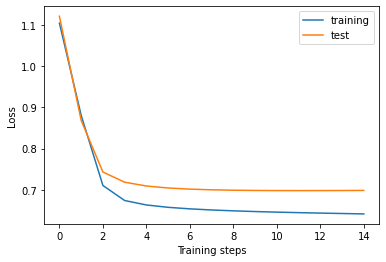

Current train loss:  tf.Tensor(0.64153516, shape=(), dtype=float32)
Change of train loss to previous epoch:  tf.Tensor(-0.0009799004, shape=(), dtype=float32)
Current test loss:  0.6985616
Change of test loss to previous epoch:  0.00023311377


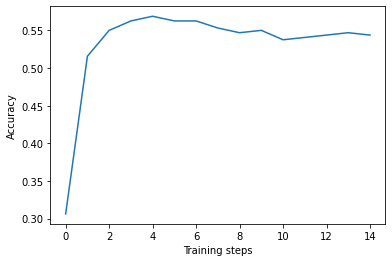

Current test accuracy:  0.54375
Change of test_accuracy to previous epoch:  -0.0031250000000000444
Epoch: __ 14


KeyboardInterrupt: ignored

In [22]:
tf.keras.backend.clear_session()

running_average_factor = 0.95
state_size = 10
timesteps = 23
model = Model(state_size, timesteps)
#train_dataset = create_dataset(2048, timesteps)
#test_dataset = create_dataset(320, timesteps)

num_epochs = 20
learning_rate = 0.001
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin

test_loss, test_accuracy = test(model, test_dataset, loss_fn)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, loss_fn)
train_losses.append(train_loss)

start = time.time()

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, loss_fn, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    clear_output(wait = True)
    print("Time until training is finished: ", calculateTime(epoch, time.time()-start, num_epochs))
    print("Visualization of Training/Test loss:")
    visualize()